**🧠 Projeto Final do Bootcamp CDIA**

---



**💻 Importações e Upload**

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from google.colab import files
from sklearn.metrics import f1_score, precision_score, recall_score

!pip install xgboost

In [ ]:
uploaded = files.upload()
df = pd.read_excel("bootcamp_train.xlsx")

**💻 Pré-processamento**

In [20]:
label_cols = [col for col in df.columns if col.startswith("falha_")]

In [21]:
def padronizar_binario(valor):
    if str(valor).strip().lower() in ['1', 'true', 's', 'sim', 'y', 'yes']:
        return 1
    else:
        return 0

In [24]:
for col in label_cols:
    df[col] = df[col].apply(padronizar_binario)

In [25]:
entrada_cols = [col for col in df.columns if col not in label_cols + ['id']]
for col in entrada_cols:
    if df[col].dtype == 'object' or df[col].apply(lambda x: isinstance(x, str)).any():
        df[col] = df[col].apply(padronizar_binario)

**📊 Exploração Visual dos Dados de Entrada**

In [26]:
display(df.head())

,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,indice_de_luminosidade,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros
0,0,154,169.0,260124,260136,100,75,27,17,9948.0,...,362.0,3068.0,125,0,0,0,0,0,0,1
1,1,1121,-186.0,1789332,1789337,100,-206,9,-194,2240.0,...,294.0,1441.0,115,0,0,0,1,0,0,0
2,2,41,216.0,2708878,2708939,100,6298,275,134,654634.0,...,-1879.0,1.0,42,0,0,1,0,0,0,0
3,3,129,157.0,86408,86427,100,276,39,26,33858.0,...,-416.0,8223.0,115,0,0,1,0,0,0,0
4,4,436,442.0,4959398,530985,100,63,17,17,6374.0,...,-2096.0,2083.0,90,0,1,0,0,0,0,0


In [27]:
print("Formato do dataset:", df.shape)
print("\nTipos de dados:\n", df.dtypes)
print("\nDados ausentes por coluna:\n", df.isnull().sum())
print("\nColunas de falhas:", label_cols)
print("\nColunas de entrada:", entrada_cols)

Formato do dataset: (3390, 39)

Tipos de dados:
 id                                int64
x_minimo                          int64
x_maximo                        float64
y_minimo                          int64
y_maximo                          int64
peso_da_placa                     int64
area_pixels                       int64
perimetro_x                       int64
perimetro_y                       int64
soma_da_luminosidade            float64
maximo_da_luminosidade          float64
comprimento_do_transportador      int64
tipo_do_aço_A300                  int64
tipo_do_aço_A400                  int64
espessura_da_chapa_de_aço       float64
temperatura                       int64
index_de_bordas                 float64
index_vazio                     float64
index_quadrado                  float64
index_externo_x                 float64
indice_de_bordas_x              float64
indice_de_bordas_y              float64
indice_de_variacao_x            float64
indice_de_variacao_y           

In [28]:
print("\nDistribuição das falhas no dataset:")
print(df[label_cols].sum().sort_values(ascending=False))


Distribuição das falhas no dataset:
falha_outros    1184
falha_6          806
falha_3          649
falha_1          275
falha_2          264
falha_4          116
falha_5           96
dtype: int64


<Figure size 1600x1500 with 0 Axes>

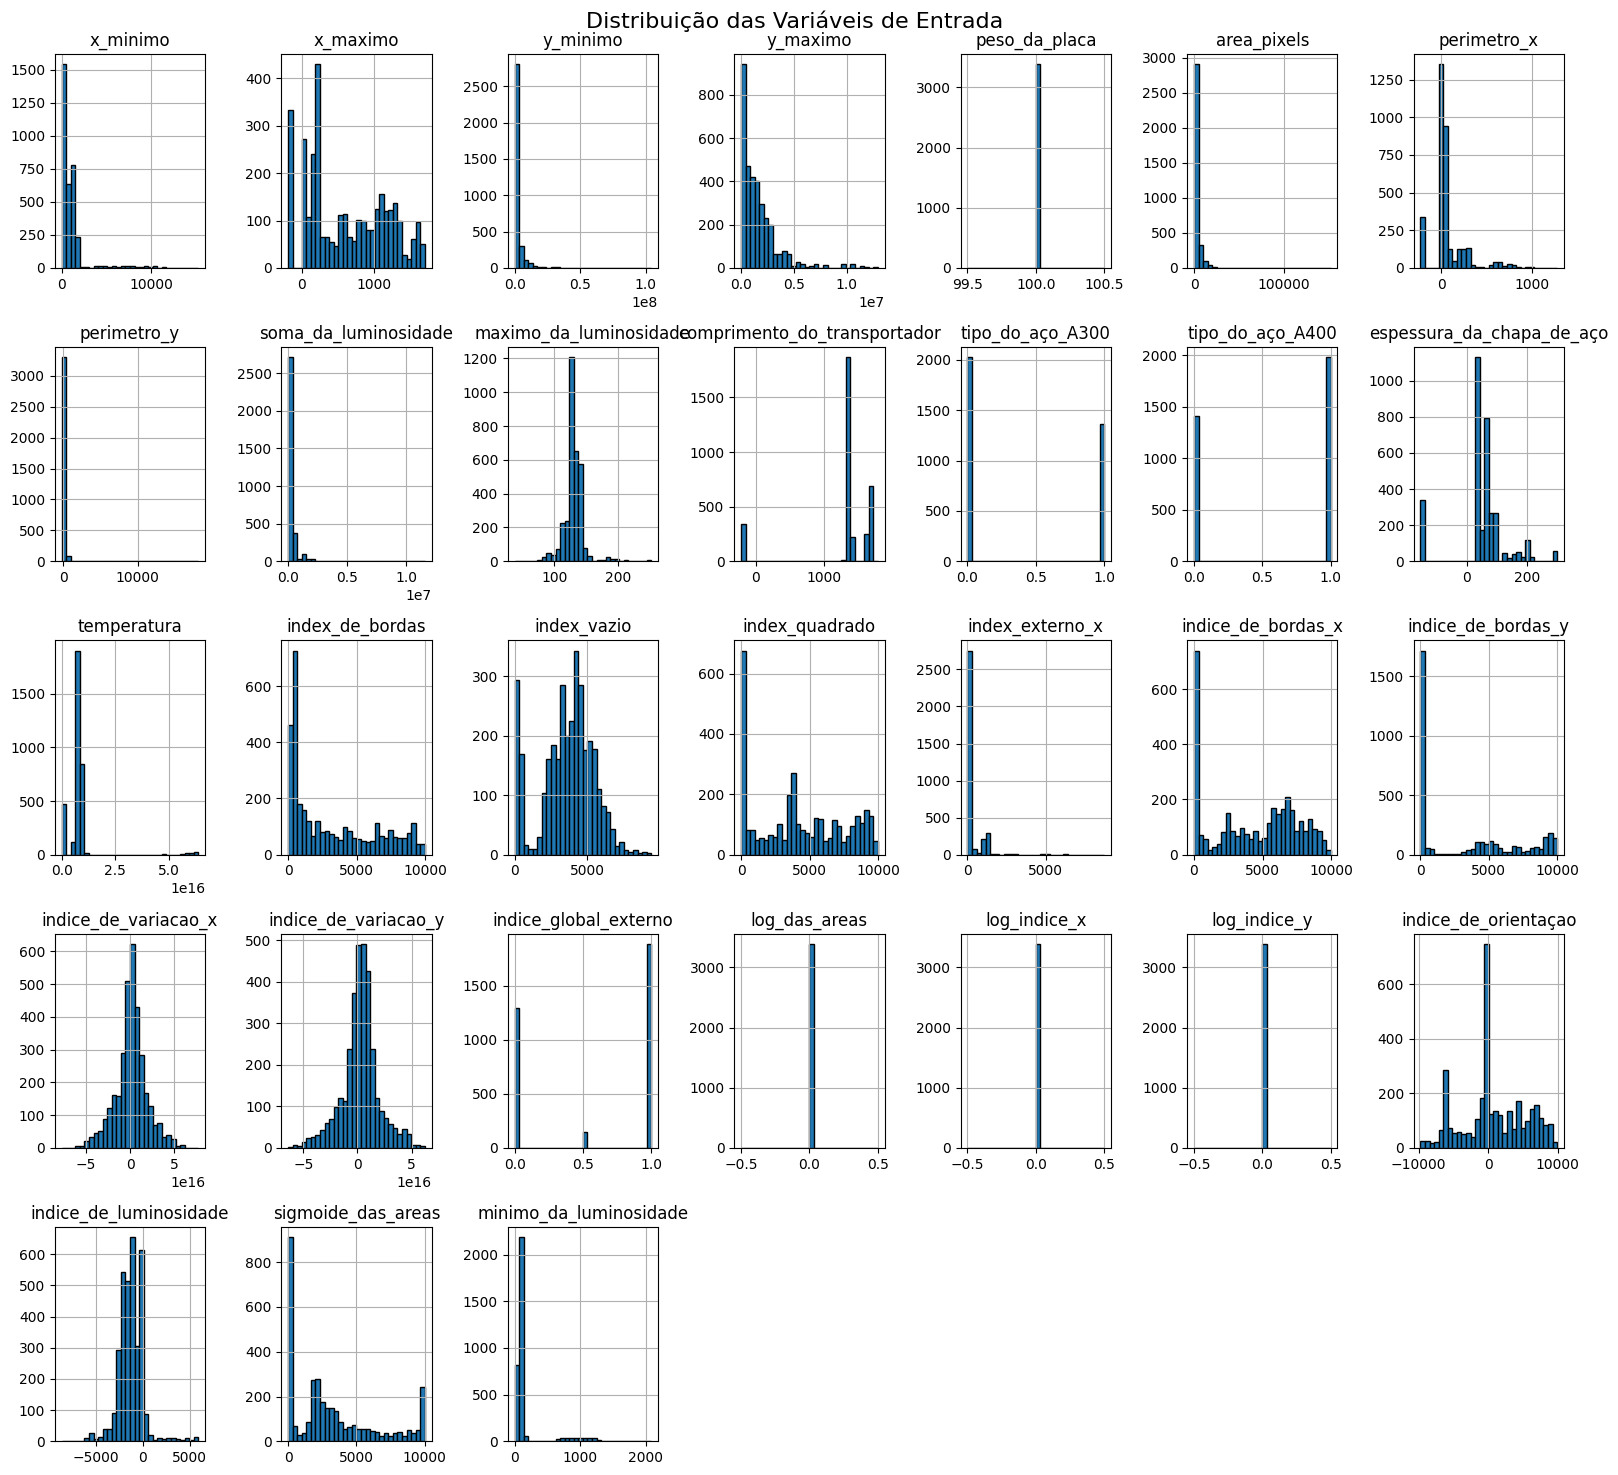

In [30]:
num_vars = len(entrada_cols)
num_linhas = (num_vars // 7) + 1
plt.figure(figsize=(16, num_linhas * 3))
df[entrada_cols].hist(bins=30, figsize=(16, num_linhas * 3), layout=(num_linhas, 7), edgecolor='black')
plt.suptitle("Distribuição das Variáveis de Entrada", fontsize=16)
plt.tight_layout()
plt.show()


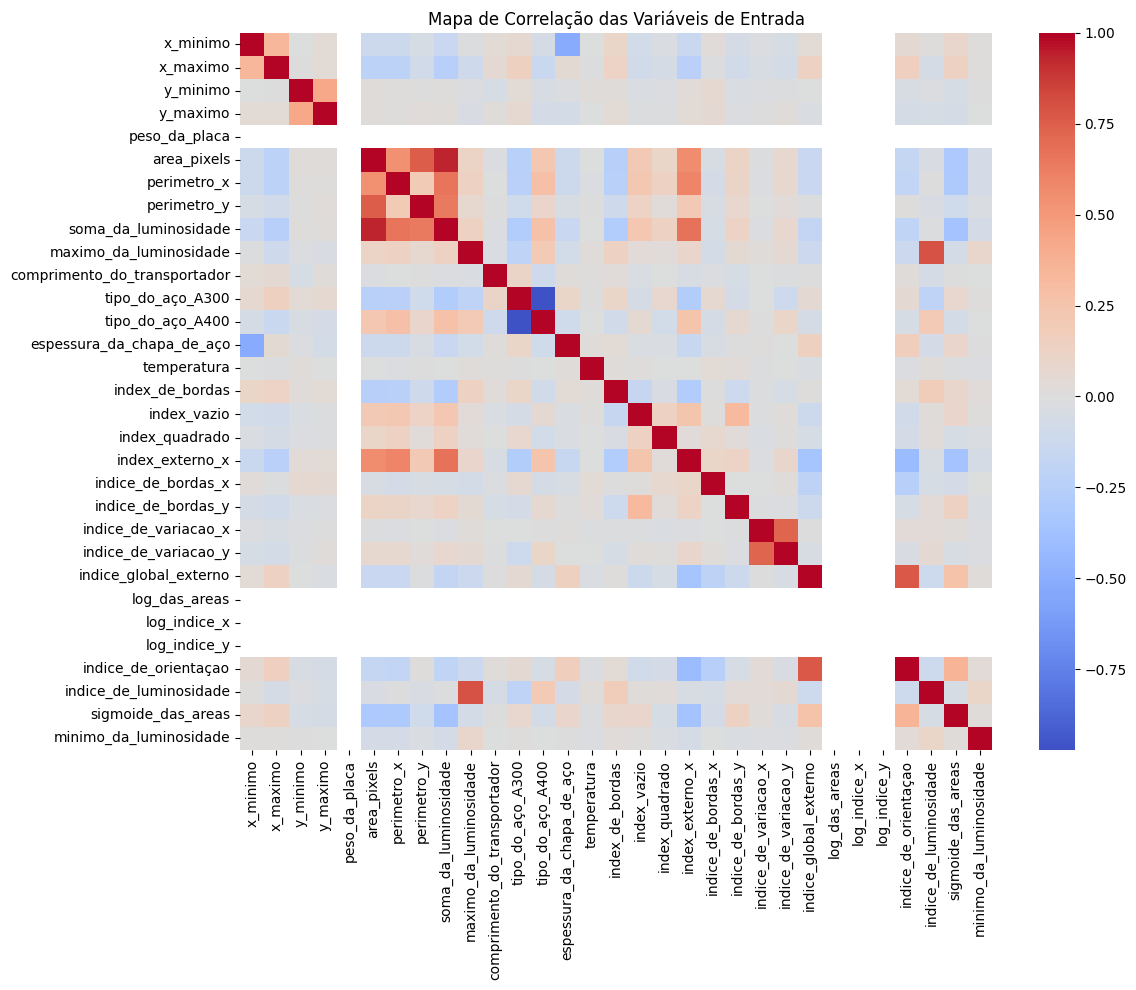

In [31]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[entrada_cols].corr(), cmap='coolwarm', center=0, annot=False)
plt.title("Mapa de Correlação das Variáveis de Entrada")
plt.tight_layout()
plt.show()

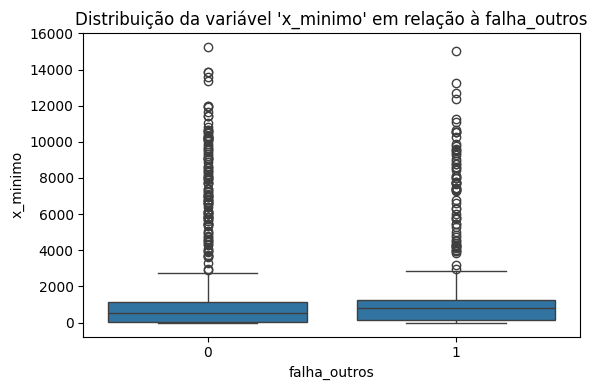

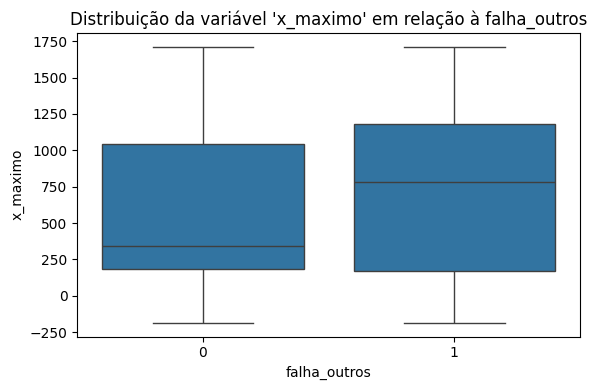

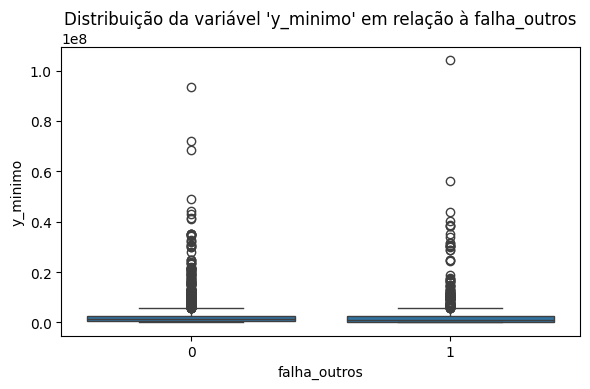

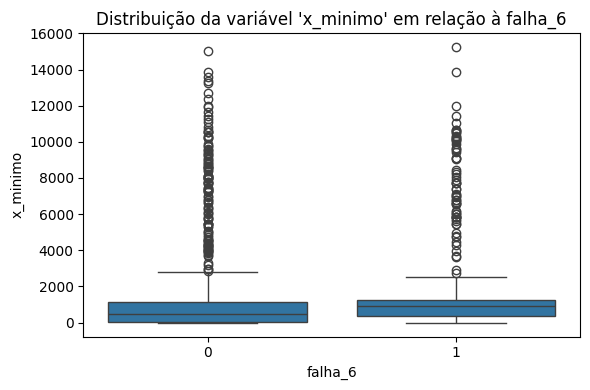

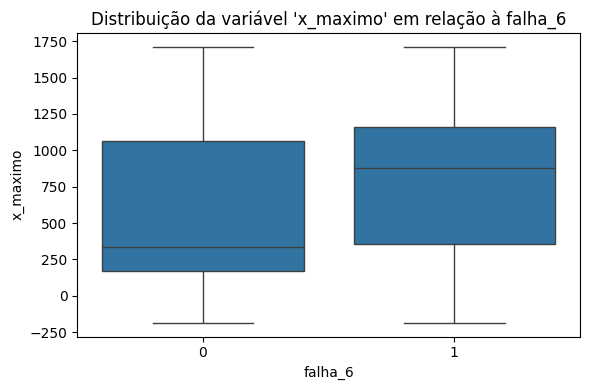

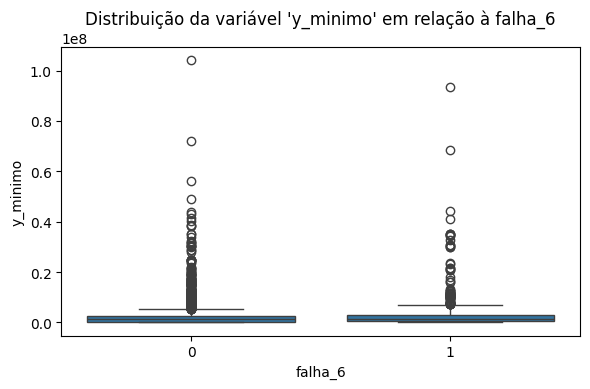

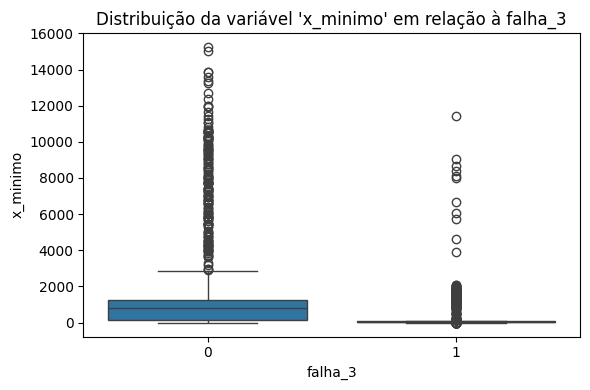

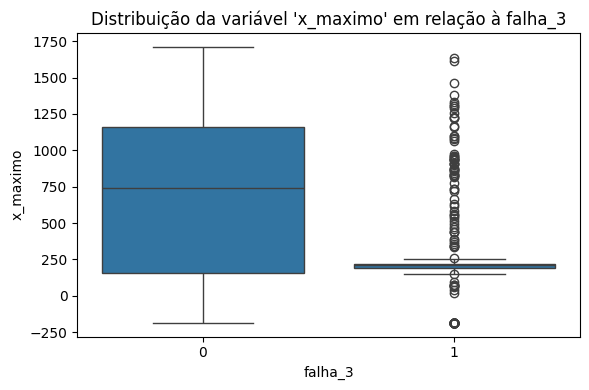

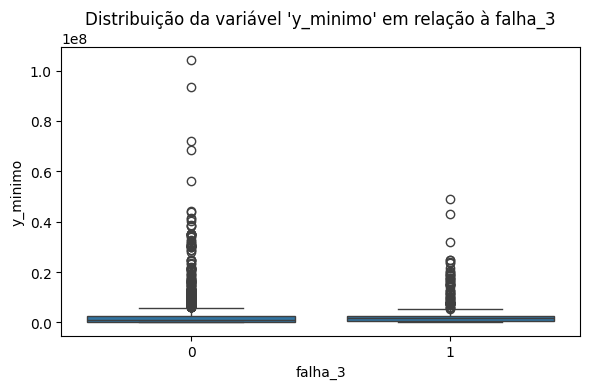

In [32]:
falhas_mais_comuns = df[label_cols].sum().sort_values(ascending=False).head(3).index.tolist()
variaveis_destaque = entrada_cols[:3]

for falha in falhas_mais_comuns:
    for var in variaveis_destaque:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[falha], y=df[var])
        plt.title(f"Distribuição da variável '{var}' em relação à {falha}")
        plt.xlabel(falha)
        plt.ylabel(var)
        plt.tight_layout()
        plt.show()

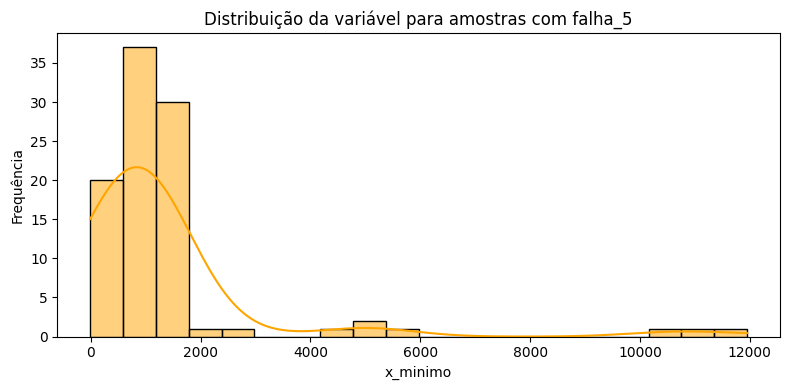

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(df[df['falha_5'] == 1][entrada_cols[0]], bins=20, kde=True, color='orange')
plt.title("Distribuição da variável para amostras com falha_5")
plt.xlabel(entrada_cols[0])
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

In [34]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[entrada_cols])
variaveis_baixa_variancia = [col for col, var in zip(entrada_cols, selector.variances_) if var < 0.01]
print("Variáveis com variância < 0.01:", variaveis_baixa_variancia)

Variáveis com variância < 0.01: ['peso_da_placa', 'log_das_areas', 'log_indice_x', 'log_indice_y']


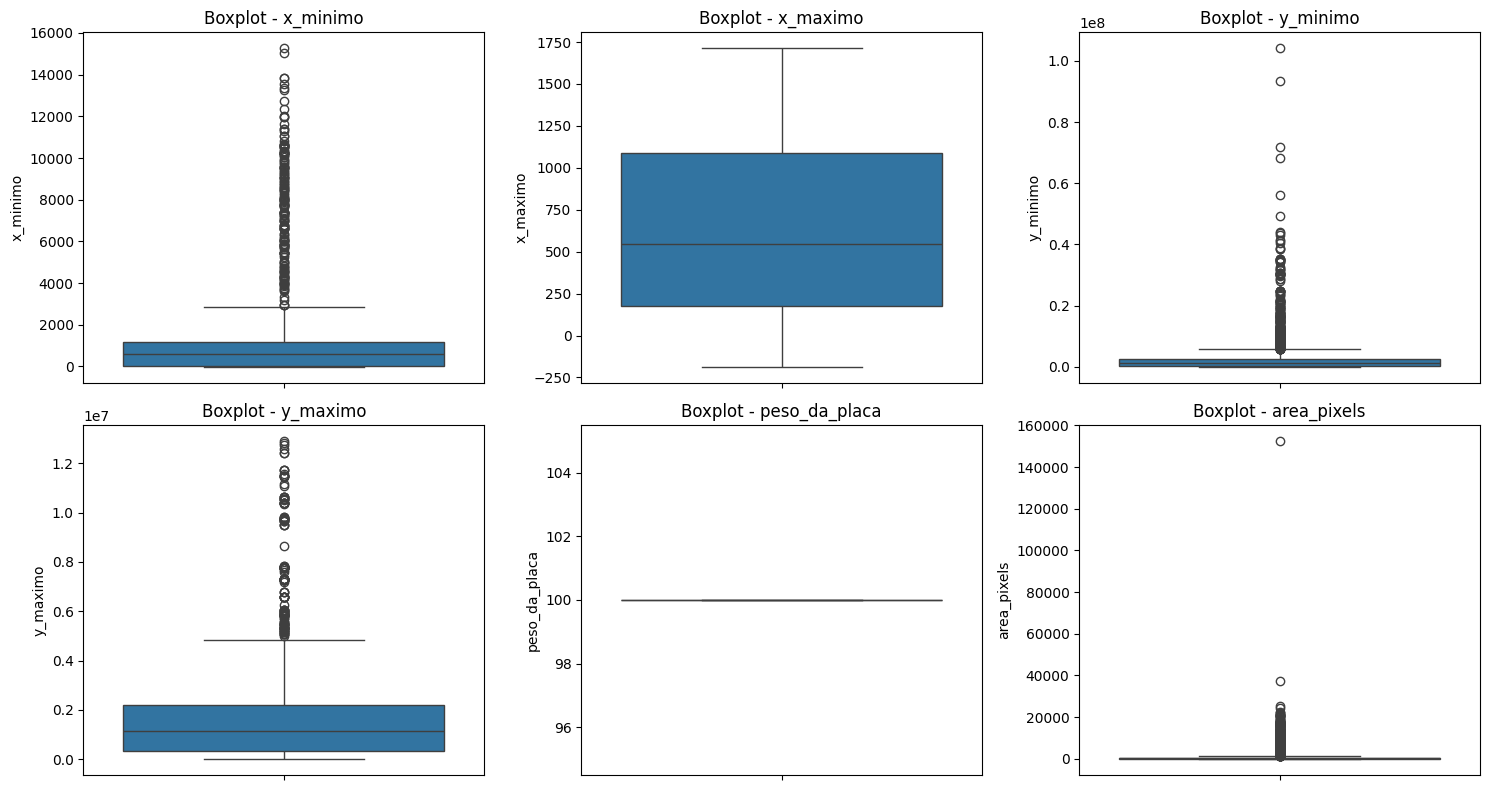

In [35]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(entrada_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot - {col}")
plt.tight_layout()
plt.show()

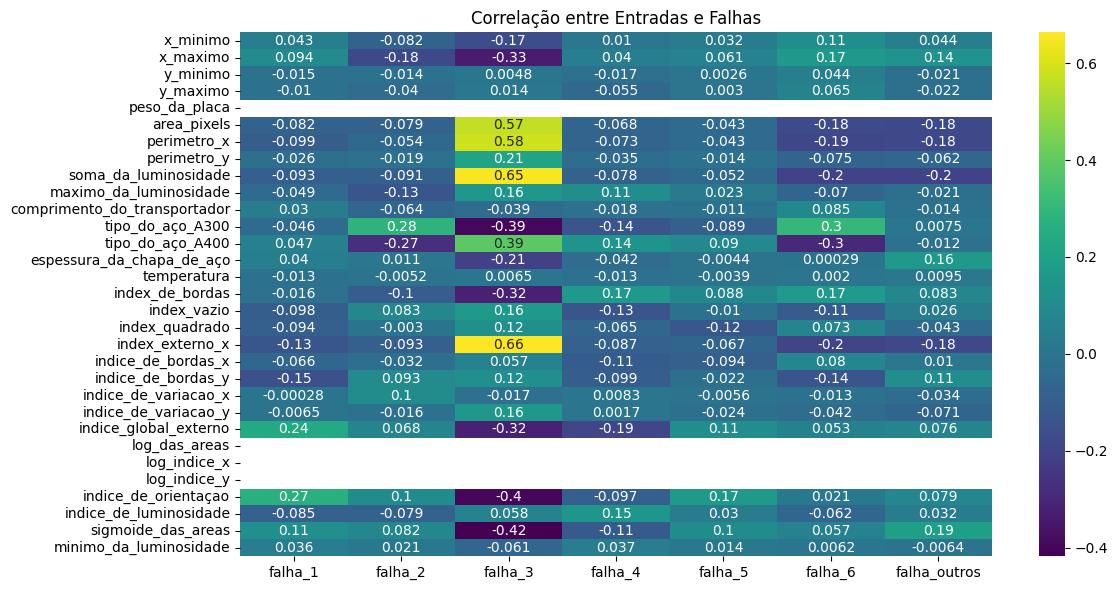

In [36]:
df_corr = pd.concat([df[entrada_cols], df[label_cols]], axis=1)
corr_cross = df_corr.corr().loc[entrada_cols, label_cols]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_cross, cmap='viridis', annot=True)
plt.title("Correlação entre Entradas e Falhas")
plt.tight_layout()
plt.show()

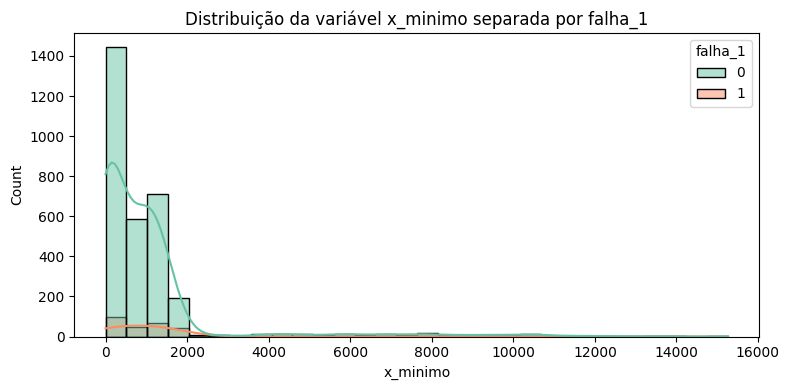

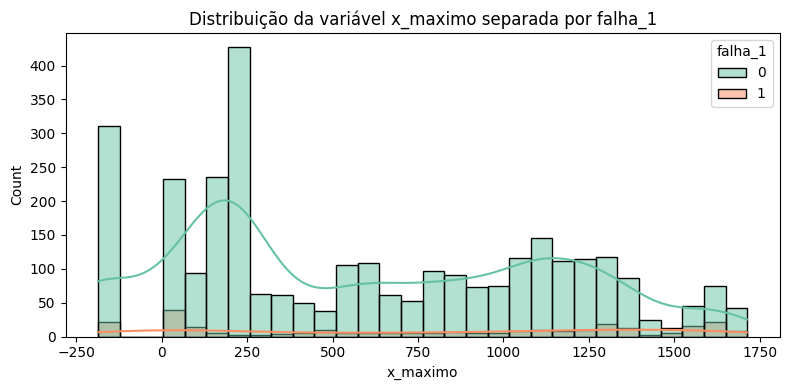

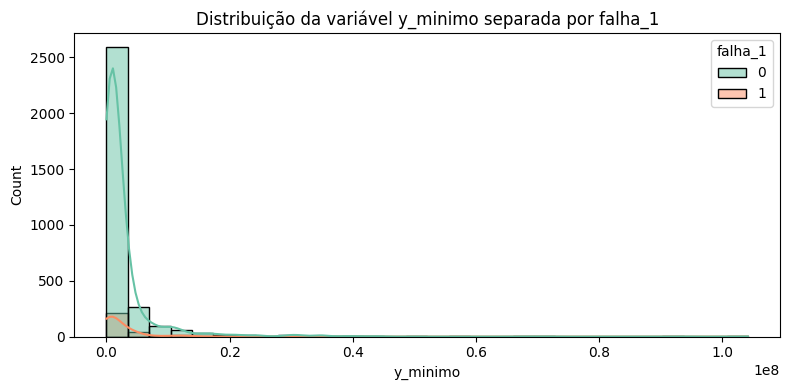

In [37]:
falha_top = label_cols[0]
for col in entrada_cols[:3]:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue=falha_top, bins=30, kde=True, palette='Set2')
    plt.title(f"Distribuição da variável {col} separada por {falha_top}")
    plt.tight_layout()
    plt.show()

**💻 Divisão Treinamento / Validação**

In [45]:
X = df.drop(columns=label_cols + ['id'])
Y = df[label_cols]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

**💻 Treinamento dos modelos**

In [46]:
modelo_rf = MultiOutputClassifier(RandomForestClassifier(random_state=42))
modelo_rf.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [47]:
modelo_rf_bal = MultiOutputClassifier(RandomForestClassifier(random_state=42, class_weight='balanced'))
modelo_rf_bal.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       random_state=42))

In [48]:
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1,
    random_state=42
)
modelo_xgb = MultiOutputClassifier(xgb)
modelo_xgb.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:01:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:01:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

**💻 Avaliação do modelo XBoost**

In [49]:
Y_pred_xgb = modelo_xgb.predict(X_val)
print(classification_report(Y_val, Y_pred_xgb, target_names=label_cols))

              precision    recall  f1-score   support

     falha_1       0.54      0.28      0.37        47
     falha_2       0.97      0.59      0.73        49
     falha_3       0.99      0.86      0.92       168
     falha_4       0.89      0.76      0.82        21
     falha_5       0.54      0.37      0.44        19
     falha_6       0.54      0.37      0.44       159
falha_outros       0.56      0.49      0.52       215

   micro avg       0.71      0.55      0.62       678
   macro avg       0.72      0.53      0.61       678
weighted avg       0.70      0.55      0.61       678
 samples avg       0.53      0.55      0.54       678



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
f1_macro = f1_score(Y_val, Y_pred_xgb, average='macro')
precision_macro = precision_score(Y_val, Y_pred_xgb, average='macro')
recall_macro = recall_score(Y_val, Y_pred_xgb, average='macro')

f1_micro = f1_score(Y_val, Y_pred_xgb, average='micro')
precision_micro = precision_score(Y_val, Y_pred_xgb, average='micro')
recall_micro = recall_score(Y_val, Y_pred_xgb, average='micro')

print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Micro F1-score: {f1_micro:.4f}")
print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")

Macro F1-score: 0.6056
Macro Precision: 0.7170
Macro Recall: 0.5316
Micro F1-score: 0.6192
Micro Precision: 0.7057
Micro Recall: 0.5516


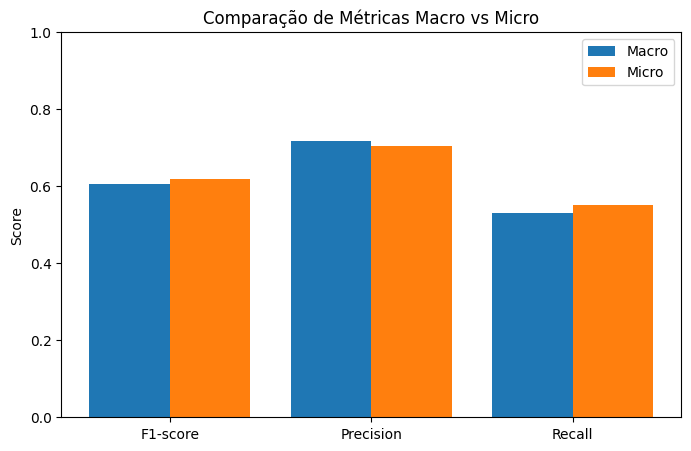

In [51]:
metrics_names = ['F1-score', 'Precision', 'Recall']
macro_scores = [f1_macro, precision_macro, recall_macro]
micro_scores = [f1_micro, precision_micro, recall_micro]

x = range(len(metrics_names))

plt.figure(figsize=(8, 5))
plt.bar(x, macro_scores, width=0.4, label='Macro', align='center')
plt.bar([p + 0.4 for p in x], micro_scores, width=0.4, label='Micro', align='center')
plt.xticks([p + 0.2 for p in x], metrics_names)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Comparação de Métricas Macro vs Micro')
plt.legend()
plt.show()

**💻 Submissão final**

In [ ]:
df_test = pd.read_excel("bootcamp_test.xlsx")

In [ ]:
entrada_cols = [col for col in df_test.columns if col != 'id']
for col in entrada_cols:
    if df_test[col].dtype == 'object' or df_test[col].apply(lambda x: isinstance(x, str)).any():
        df_test[col] = df_test[col].apply(padronizar_binario)

In [ ]:
X_test = df_test[X.columns]
df_pred = pd.DataFrame(modelo_xgb.predict(X_test), columns=label_cols)
df_pred['id'] = df_test['id']
df_submission = df_pred[['id'] + label_cols]
df_submission.to_excel("final_submission.xlsx", index=False)
files.download("final_submission.xlsx")

**💻 Probalidades previstas**

In [ ]:
probas = modelo_xgb.predict_proba(X_test)
proba_dict = {label_cols[i]: probas[i][:, 1] for i in range(len(label_cols))}
df_probas = pd.DataFrame(proba_dict)
df_probas['id'] = df_test['id']
df_probas = df_probas[['id'] + label_cols]

In [ ]:
df_probas.head()

In [ ]:
df_probas.iloc[0]

In [ ]:
df_probas[label_cols].mean().sort_values(ascending=False)

**📊 Gráficos**

In [ ]:
frequencias = Y.sum().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=frequencias.index, y=frequencias.values)
plt.title("Frequência de cada classe nos dados de treino")
plt.ylabel("Número de amostras")
plt.xlabel("Classe de falha")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
report_dict = classification_report(Y_val, Y_pred_xgb, target_names=label_cols, output_dict=True)
f1_scores = {k: v['f1-score'] for k, v in report_dict.items() if k in label_cols}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title("F1-score por classe - Modelo XGBoost")
plt.ylabel("F1-score")
plt.xlabel("Classe de falha")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df_probas['falha_5'], bins=20, kde=True, color='orange')
plt.title("Distribuição das probabilidades para falha_5")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

In [ ]:
f1_rf = {
    "falha_1": 0.04,
    "falha_2": 0.65,
    "falha_3": 0.93,
    "falha_4": 0.78,
    "falha_5": 0.26,
    "falha_6": 0.42,
    "falha_outros": 0.53
}
comparacao_df = pd.DataFrame({"RandomForest": f1_rf, "XGBoost": f1_scores})
comparacao_df.plot(kind="bar", figsize=(10, 6), rot=45, color=["#1f77b4", "#ff7f0e"])
plt.title("Comparacão de Desempenho (F1-score) por Classe de Falha", fontsize=14)
plt.ylabel("F1-score")
plt.xlabel("Classe de Falha")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Modelos", labels=["Random Forest", "XGBoost"], loc="upper right")
plt.tight_layout()
plt.savefig("comparacao_f1score_modelos.png", dpi=300)
plt.show()